In [1]:
import os
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
import rdkit
print(rdkit.__version__)
from src.cheminfo_utils import save_json, get_compound_hash, get_reaction_hash, postsanitize_smiles, neutralise_charges, smarts_to_sub_smiles, sub_smiles_to_smarts
from collections import Counter, defaultdict, namedtuple
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from src.post_processing import DatabaseEntry, Enzyme, load_known_rxns

def sanitize(reactants, products):
    return postsanitize_smiles(reactants)[0], postsanitize_smiles(products)[0]

def neutralize(reactants, products):
    reactants = [Chem.MolToSmiles(neutralise_charges(Chem.MolFromSmiles(elt, sanitize=False))) for elt in reactants]
    products = [Chem.MolToSmiles(neutralise_charges(Chem.MolFromSmiles(elt, sanitize=False))) for elt in products]
    return reactants, products

def get_rhash(reactants, products):
    reactants_hash_stoich = list(Counter([get_compound_hash(elt)[0] for elt in reactants]).items())
    products_hash_stoich = list(Counter([get_compound_hash(elt)[0] for elt in products]).items())
    rhash = get_reaction_hash(reactants_hash_stoich, products_hash_stoich)
    return rhash

def load_known_rxns_old(path):
    # Old named tuples
    DatabaseEntry = namedtuple("DatabaseEntry", "db, id", defaults=[None, None])
    Enzyme = namedtuple("Enzyme", "uniprot_id, sequence, validation_score, existence, reviewed, organism", defaults=[None, None, None, None, None, None])

    with open(path, 'r') as f:
        data = json.load(f)

    for _,v in data.items():

        # Convert enzymes and db entries to namedtuples
        enzymes = [Enzyme(*elt) for elt in v['enzymes']]
        v['enzymes'] = enzymes

        db_entries = [DatabaseEntry(*elt) for elt in v['db_entries']]
        v['db_entries'] = db_entries

    return data

2023.03.2


In [2]:
# Load known reactions
known_rxns = load_known_rxns_old("../data/mapping/known_rxns_swissprot_enzymes_240310.json")

# Load bkm reactions
with open("../data/mapping/known_rxns_jni.json", 'r') as f:
    bkm_rxns = json.load(f)

# Load updated sprhea known
known_rxns_v2 = load_known_rxns("../data/mapping/known_rxns_swissprot_enzymes_240310_v2.json")

# compare reactions

In [63]:
# What is overlap between spr and bkm rhashes?

intersection = set(known_rxns.keys()) & set(bkm_rxns.keys())
union = set(known_rxns.keys()) | set(bkm_rxns.keys())
print(f"{len(intersection)  / len(union)}")
print(f"{len(intersection)  / len(known_rxns)}")

0.15383748994368462
0.4690903738592876


In [ ]:
# Load mc and kegg links from rhea

rhea2kegg = pd.read_csv("../data/mapping/rhea2kegg_reaction.tsv", sep='\t')
rhea2kegg.set_index('RHEA_ID', inplace=True)

rhea2metacyc = pd.read_csv("../data/mapping/rhea2metacyc.tsv", sep='\t')
rhea2metacyc.set_index('RHEA_ID', inplace=True)

In [29]:
# How many of my spr overlap w/ kegg? None!?

for k, v in known_rxns.items():
    for db, id in v['db_entries']:
        if id in rhea2kegg.index:
            print(id)
            break

In [50]:
# How many of my spr overlap w/ metacyc?

hash_match_metacyc = set()
rhea_mc_val = defaultdict(list)
for k, v in known_rxns.items():
    for db, id in v['db_entries']:
        if id in rhea2metacyc.index:
            hash_match_metacyc.add(k)
            rhea_mc_val[k].append(rhea2metacyc.loc[id, 'ID'])

print(len(hash_match_metacyc))

9346


In [5]:
rhea2sp = pd.read_csv("../data/mapping/rhea2uniprot_sprot.tsv", sep='\t')
rhea2sp.set_index("RHEA_ID", inplace=True)
rhea2sp.head()

,DIRECTION,MASTER_ID,ID
RHEA_ID,,,
10008,UN,10008,O17433
10008,UN,10008,O34564
10008,UN,10008,P0C0L2
10008,UN,10008,P0C0L3
10008,UN,10008,P23161


In [7]:
unique_rhea_ids_sp = set(rhea2sp.index)
print(len(unique_rhea_ids_sp ), len(known_rxns))
unique_rhea_ids_kegg = set(rhea2kegg.index)
print(len(unique_rhea_ids_kegg))
print(len(unique_rhea_ids_kegg & unique_rhea_ids_sp))

19499 20382


NameError: name 'rhea2kegg' is not defined

In [51]:
# Are the outlinked rhea to mc the same as I have in known rxns?

for hash in hash_match_metacyc:
    if hash in bkm_rxns:
        for db_id in bkm_rxns[hash]['db_ids']:
            db, id = db_id.split(":")
            if db == 'metacyc':
                id = id.split('_')[0]
                print(id, rhea_mc_val[hash])

RXN-12239 ['RXN-12239', 'RXN-10003']
RXN-10003 ['RXN-12239', 'RXN-10003']
RXN-8422 ['RXN-8422']
R222-RXN ['R222-RXN']
ECDYSONE-OXIDASE-RXN ['ECDYSONE-OXIDASE-RXN']
2.1.1.128-RXN ['2.1.1.128-RXN']
RXN-5141 ['2.1.1.128-RXN']
RXN-8495 ['RXN-8495']
TUBULIN-N-ACETYLTRANSFERASE-RXN ['RXN0-7160', 'HISTONE-ACETYLTRANSFERASE-RXN']
RXN-14104 ['RXN-14104']
RXN-12767 ['RXN-12767']
URATE-OXIDASE-RXN ['URATE-OXIDASE-RXN']
RXN-16819 ['RXN-16819']
RXN-7938 ['RXN-7938']
SALICYLATE-1-MONOOXYGENASE-RXN ['SALICYLATE-1-MONOOXYGENASE-RXN']
RXN-15130 ['RXN-15130']
2.7.1.149-RXN ['2.7.1.149-RXN']
RXN0-705 ['RXN0-705']
RXN-15776 ['RXN-15776']
NMNAMIDOHYDRO-RXN ['NMNAMIDOHYDRO-RXN']
2.4.1.195-RXN ['2.4.1.195-RXN']
2.4.99.10-RXN ['2.4.99.10-RXN']
GLY3KIN-RXN ['GLY3KIN-RXN']
CHER-RXN ['CHER-RXN']
RXN-1484 ['RXN-1484']
INOSINATE-NUCLEOSIDASE-RXN ['INOSINATE-NUCLEOSIDASE-RXN']
RXN-12200 ['RXN-12200']
RXN-17978 ['RXN-17978']
RXN6666-4 ['RXN6666-4']
RXN-4961 ['RXN-4961']
LACTOYL-COA-DEHYDRATASE-RXN ['LACTOYL-COA-DEHY

In [68]:
# Are all amino acid sequences in my known reaction enzymes unique?

seqs_known_rxns = set()

for v in known_rxns.values():
    for e in v['enzymes']:
        seqs_known_rxns.add(e[1])

len(seqs_known_rxns)

6151

# Compare uniprot ids / enzymes

In [ ]:
'''
TODO: 

- How many enzymes per reaction currently?
- What fraction of those are Evidence level = Protein?
- What if I added in all from csv file: how many reactions added?
how many enzymes per reaction? How many if I keep only protein level evidence?
- EC distribution
'''

In [6]:
# Do I have all the uniprot ids in my known rxns that I could?

up_ids_known_rxns = set()
up_ids_known_rxns_v2 = set()
up_ids_rhea_val = set(rhea2sp.loc[:, 'ID'])

for v in known_rxns.values():
    for e in v['enzymes']:
        up_ids_known_rxns.add(e.uniprot_id)

for v in known_rxns_v2.values():
    for e in v['enzymes']:
        up_ids_known_rxns_v2.add(e.uniprot_id)

# v1
print('v1')
print(len(up_ids_known_rxns & up_ids_rhea_val) / len(up_ids_known_rxns | up_ids_rhea_val))
print(len(up_ids_known_rxns), len(up_ids_rhea_val))

# v2
print('v2')
print(len(up_ids_known_rxns_v2 & up_ids_rhea_val) / len(up_ids_known_rxns_v2 | up_ids_rhea_val))
print(len(up_ids_known_rxns_v2), len(up_ids_rhea_val))

v1
0.02665459491773594
6153 230842
v2
0.9373944741239729
216669 230842


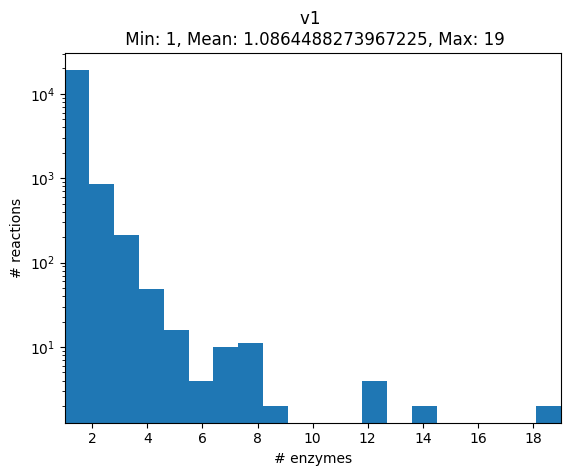

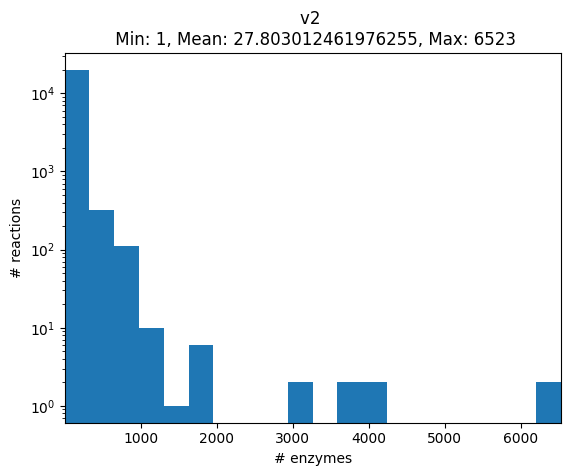

In [7]:
enzymes_per_reaction_240310 = {k: len(v['enzymes']) for k,v in known_rxns.items()}
vals = np.array(list(enzymes_per_reaction_240310.values()))
plt.hist(enzymes_per_reaction_240310.values(), bins=20)
plt.yscale('log')
plt.xlim(1, vals.max())
plt.xlabel('# enzymes')
plt.ylabel('# reactions')
plt.title(f"v1 \n Min: {vals.min()}, Mean: {vals.mean()}, Max: {vals.max()}")
plt.show()

enzymes_per_reaction_240310 = {k: len(v['enzymes']) for k,v in known_rxns_v2.items()}
vals = np.array(list(enzymes_per_reaction_240310.values()))
plt.hist(enzymes_per_reaction_240310.values(), bins=20)
plt.yscale('log')
plt.xlim(1, vals.max())
plt.xlabel('# enzymes')
plt.ylabel('# reactions')
plt.title(f"v2 \n Min: {vals.min()}, Mean: {vals.mean()}, Max: {vals.max()}")
plt.show()



In [8]:
evidence_levels = set()
for v in known_rxns.values():
    evidence_levels.add(v['enzymes'][0].existence)
print(evidence_levels)

{'Predicted', 'Evidence at protein level', 'Evidence at transcript level', 'Uncertain', 'Inferred from homology'}


In [9]:
# How many enzymes at each level of evidence

evidence_level_cts = {level: 0 for level in evidence_levels}
up_ids_known_rxns = set()

for v in known_rxns.values():
    for e in v['enzymes']:
        if e.uniprot_id not in up_ids_known_rxns:
            up_ids_known_rxns.add(e.uniprot_id)
            evidence_level_cts[e.existence] += 1

print("v1: ", evidence_level_cts)


up_ids_known_rxns_v2 = set()

for v in known_rxns_v2.values():
    for e in v['enzymes']:
        if e.uniprot_id not in up_ids_known_rxns:
            up_ids_known_rxns.add(e.uniprot_id)
            evidence_level_cts[e.existence] += 1

print("v2: ", evidence_level_cts)



v1:  {'Predicted': 6, 'Evidence at protein level': 5668, 'Evidence at transcript level': 261, 'Uncertain': 3, 'Inferred from homology': 215}
v2:  {'Predicted': 96, 'Evidence at protein level': 31471, 'Evidence at transcript level': 11053, 'Uncertain': 70, 'Inferred from homology': 173979}


In [10]:
# How many reactions, how many enzymes per reaction if I limit to protein level / transcript level evidence?

datasets = [known_rxns, known_rxns_v2]
ds_names = ['v1', 'v2']

for i, dataset in enumerate(datasets):
    nr = 0
    ne_per_rxn = {}
    for k,v in dataset.items():
        ne = len([e for e in v['enzymes'] if e.existence == 'Evidence at protein level'])
        ne_per_rxn[k] = ne

        if ne > 0:
            nr += 1

    mean_enz_per_rxn = np.array([val for val in ne_per_rxn.values() if val > 0]).mean()

    print(f"{ds_names[i]}, protein level evidence: {nr} reactions, mean enzymes per reaction = {mean_enz_per_rxn}")

for i, dataset in enumerate(datasets):
    nr = 0
    ne_per_rxn = {}
    for k,v in dataset.items():
        ne = len([e for e in v['enzymes'] if e.existence == 'Evidence at protein level' or e.existence == 'Evidence at transcript level'])
        ne_per_rxn[k] = ne

        if ne > 0:
            nr += 1

    mean_enz_per_rxn = np.array([val for val in ne_per_rxn.values() if val > 0]).mean()

    print(f"{ds_names[i]}, protein / transcript level evidence: {nr} reactions, mean enzymes per reaction = {mean_enz_per_rxn}")

v1, protein level evidence: 18337 reactions, mean enzymes per reaction = 1.0815291487157115
v2, protein level evidence: 20215 reactions, mean enzymes per reaction = 5.740786544645066
v1, protein / transcript level evidence: 19695 reactions, mean enzymes per reaction = 1.0846915460776847
v2, protein / transcript level evidence: 20267 reactions, mean enzymes per reaction = 7.756944787092317


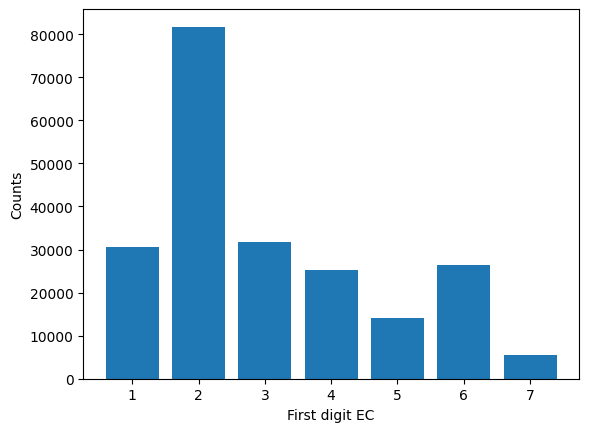

In [27]:
# Plot distribution over EC numbers

first_level_ec = defaultdict(lambda : 0)
second_level_ec = defaultdict(lambda : 0)
third_level_ec = defaultdict(lambda : 0)

unique_enzymes = set()
for k,v in known_rxns_v2.items():
    for e in v['enzymes']:
        unique_enzymes.add(e)
        
for e in unique_enzymes:        
    if e.ec:
        for ec in e.ec:
            ec_first = ec.split('.')[0]
            ec_second = ".".join(ec.split('.')[:2])
            ec_third = ".".join(ec.split('.')[:3])

            first_level_ec[ec_first] += 1
            second_level_ec[ec_second] += 1
            third_level_ec[ec_third] += 1

plt.bar([int(elt) for elt in first_level_ec.keys()], first_level_ec.values())
plt.xlabel("First digit EC")
plt.ylabel("Counts")
plt.show()

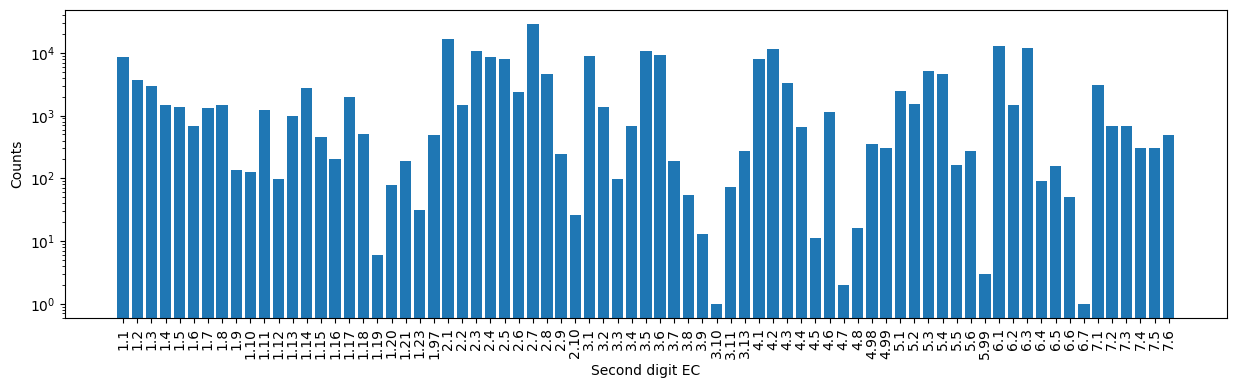

In [37]:
xtick_labels = sorted(second_level_ec.keys(), key= lambda x: [int(elt) for elt in x.split(".")])
x = np.arange(len(xtick_labels))
h = [second_level_ec[k] for k in xtick_labels]
plt.figure(figsize=(15, 4))
plt.bar(x, h)
plt.xlabel("Second digit EC")
plt.xticks(x, labels=xtick_labels, rotation=90)
plt.ylabel("Counts")
plt.yscale('log')
plt.show()

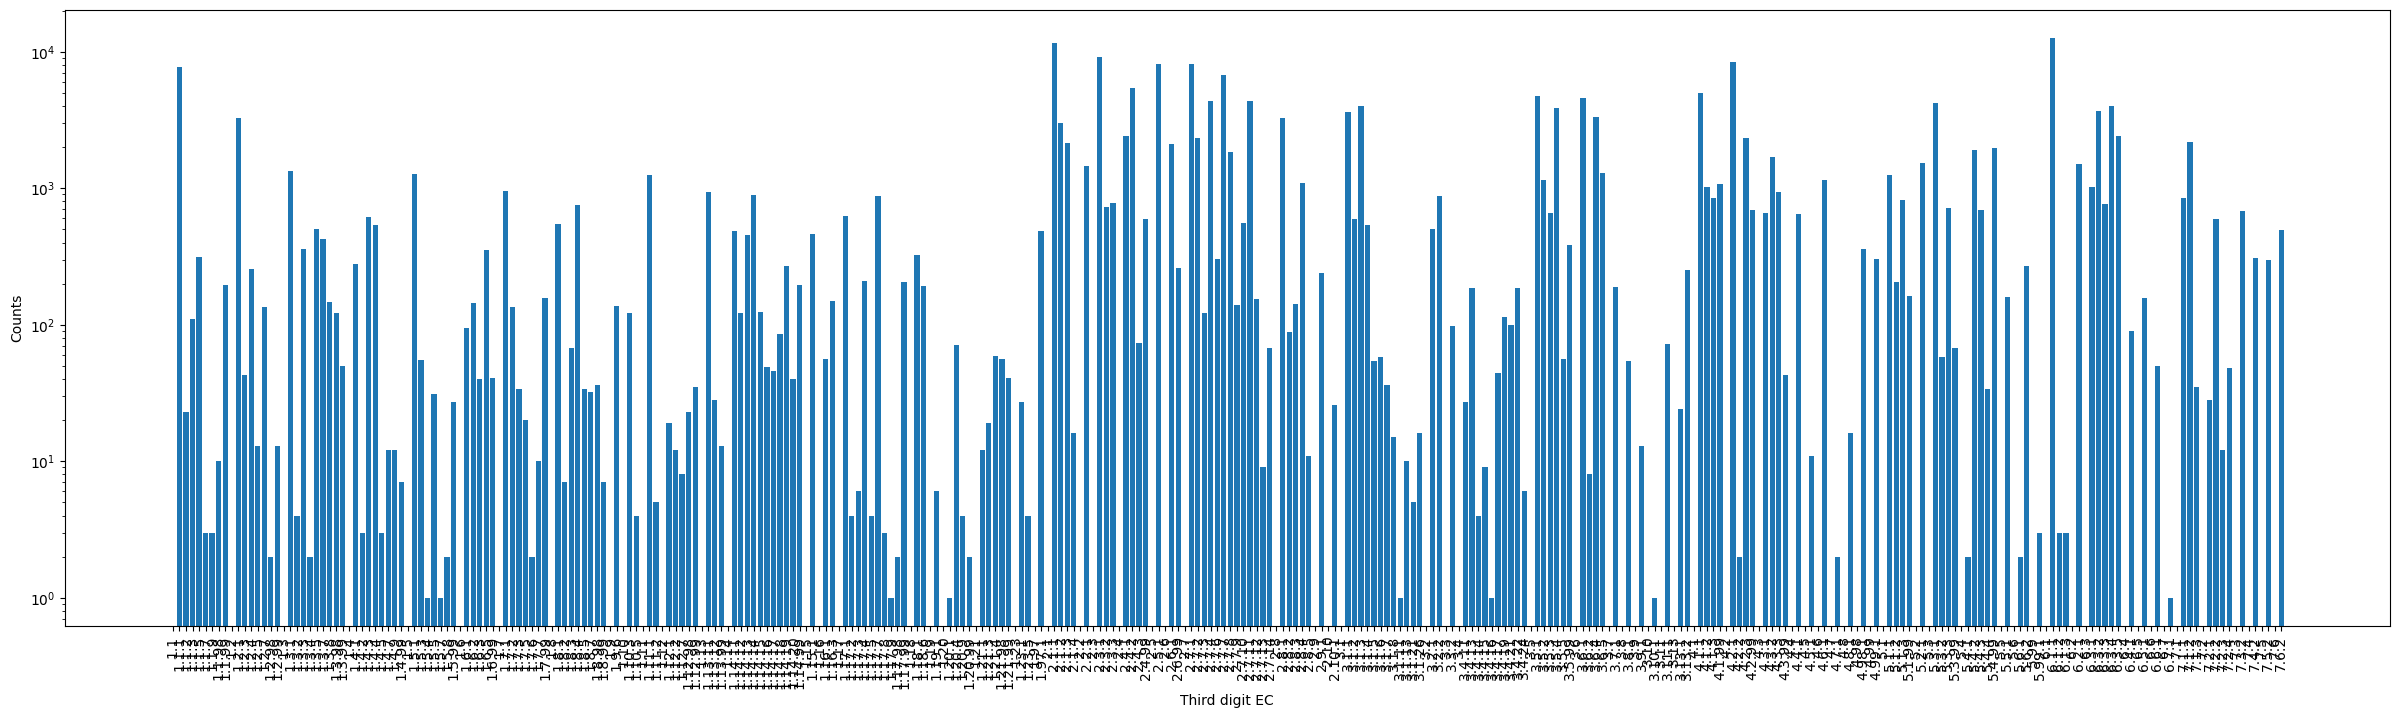

In [36]:
xtick_labels = sorted(third_level_ec.keys(), key= lambda x: [int(elt) for elt in x.split(".")])
x = np.arange(len(xtick_labels))
h = [third_level_ec[k] for k in xtick_labels]
plt.figure(figsize=(30, 8))
plt.bar(x, h)
plt.xlabel("Third digit EC")
plt.xticks(x, labels=xtick_labels, rotation=90)
plt.ylabel("Counts")
plt.yscale('log')
plt.show()

In [38]:
0.72*20_000


14400.0